In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
store_sales = pd.read_csv("train.csv")

In [ ]:
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
store_sales = store_sales.drop(['store','item'], axis=1)

In [ ]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


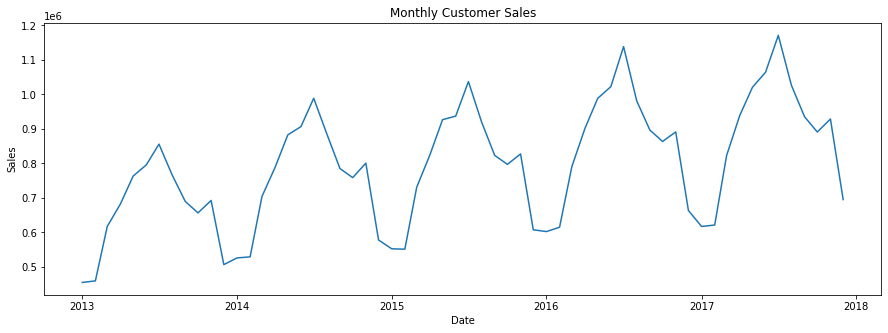

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()

In [ ]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [ ]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)

In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

In [ ]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()

In [ ]:
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [ ]:
lr_model = LinearRegression()

In [ ]:
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list = []
for i in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[i][0] + act_sales[i])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [ ]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

In [ ]:
print('Linear Regression MSE : ', lr_mse)
print('Linear Regression MAE : ', lr_mae)
print('Linear Regression R2 : ', lr_r2)

Linear Regression MSE :  16221.272385416898
Linear Regression MAE :  12433.184266490765
Linear Regression R2 :  0.9906152516380968


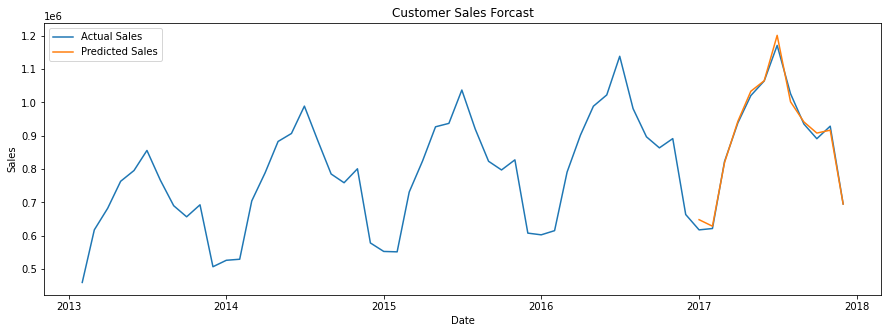

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forcast")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()